# Importing Python Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

# Dataset Overview

In [2]:
df = pd.read_csv("Restaurant_reviews.csv")
df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


# Data Cleaning

Dropping irrelevant columns

In [3]:
df = df.drop(["Reviewer", "Metadata", "Pictures" ,"7514"], axis=1)

Dealing with missing values

In [4]:
df.isnull().sum()


,0
Restaurant,0
Review,45
Rating,38
Time,38


In [5]:
df["Review"] = df["Review"].fillna("Nothing")

In [6]:
df.dropna(inplace=True) #Drop remaining null values

Converting the "Rating" column into a binary classification

In [7]:
df["Rating"].unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like'],
      dtype=object)

In [8]:
df['Rating'].value_counts().idxmax()

'5'

In [9]:
df['Rating'] = np.where(df["Rating"] == "Like", df['Rating'].value_counts().idxmax(), df['Rating'])

In [10]:
df["Rating"] = list(map(lambda data: float(data) >= 3, df["Rating"]))

In [11]:
df["Rating"].unique()

array([ True, False])

Split the "Time" column into separate day, month, and year

In [12]:
df['Time'] = pd.to_datetime(df['Time'])
df['Day'] = df.Time.dt.day_name()
df['Month'] = df.Time.dt.month
df['Week'] = df.Time.dt.weekday
df['Year'] = df.Time.dt.year

Handling Data Imbalance using Stratified Sampling

In [13]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop('Rating', axis=1)
y = df['Rating']

# Perform stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Now X_train and y_train contain the stratified samples
# You can proceed with your model training using X_train and y_train
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (7969, 7)
Test data shape: (1993, 7)


# Exploratory Data Analysis

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

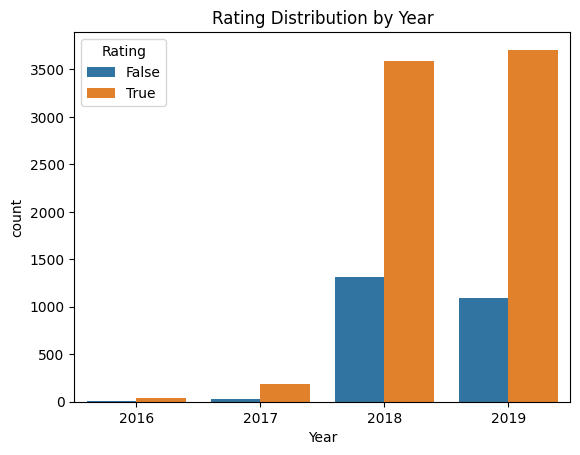

In [15]:
plt.title('Rating Distribution by Year')
sns.countplot(data = df, x = 'Year', hue = 'Rating');

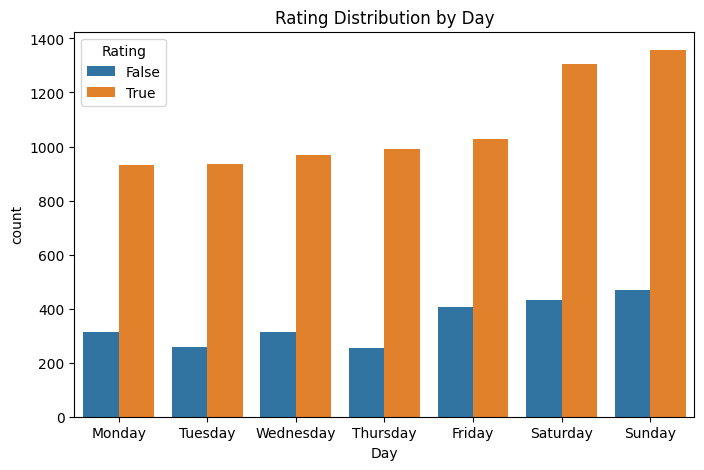

In [16]:
plt.figure(figsize=(8,5))
plt.title('Rating Distribution by Day')
sns.countplot(data = df, x = 'Day', hue = 'Rating',
              order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

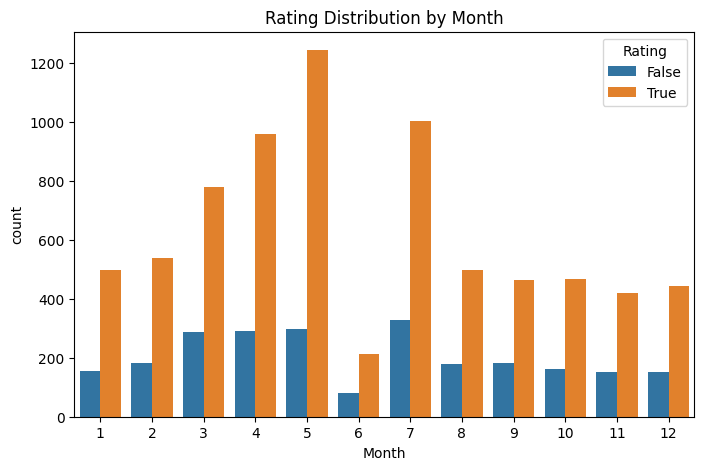

In [17]:
plt.figure(figsize=(8,5))
plt.title('Rating Distribution by Month')
sns.countplot(data = df, x = 'Month', hue = 'Rating');

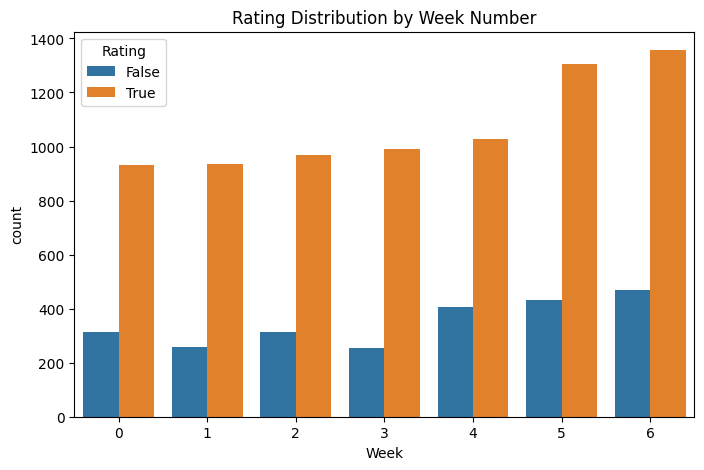

In [18]:
plt.figure(figsize=(8,5))
plt.title('Rating Distribution by Week Number')
sns.countplot(data = df, x = 'Week', hue = 'Rating');

In [19]:
#Make second data frame to count the negative and postive percentage for each retaurant
df_piv = pd.crosstab(index = df.Restaurant, columns= df.Rating, normalize= ('index')).reset_index()
df_piv.head()

Rating,Restaurant,False,True
0,10 Downing Street,0.12,0.88
1,13 Dhaba,0.29,0.71
2,"3B's - Buddies, Bar & Barbecue",0.06,0.94
3,AB's - Absolute Barbecues,0.02,0.98
4,Absolute Sizzlers,0.27,0.73


In [20]:
df_piv = pd.crosstab(index = df.Restaurant, columns= df.Rating, normalize= ('index')).reset_index()
# Rename the columns to 'Negative' and 'Positive'
df_piv.columns = ['Restaurant', 'Negative', 'Positive']
df_piv.head()

,Restaurant,Negative,Positive
0,10 Downing Street,0.12,0.88
1,13 Dhaba,0.29,0.71
2,"3B's - Buddies, Bar & Barbecue",0.06,0.94
3,AB's - Absolute Barbecues,0.02,0.98
4,Absolute Sizzlers,0.27,0.73


Text(0.5, 0, 'Restaurant Name')

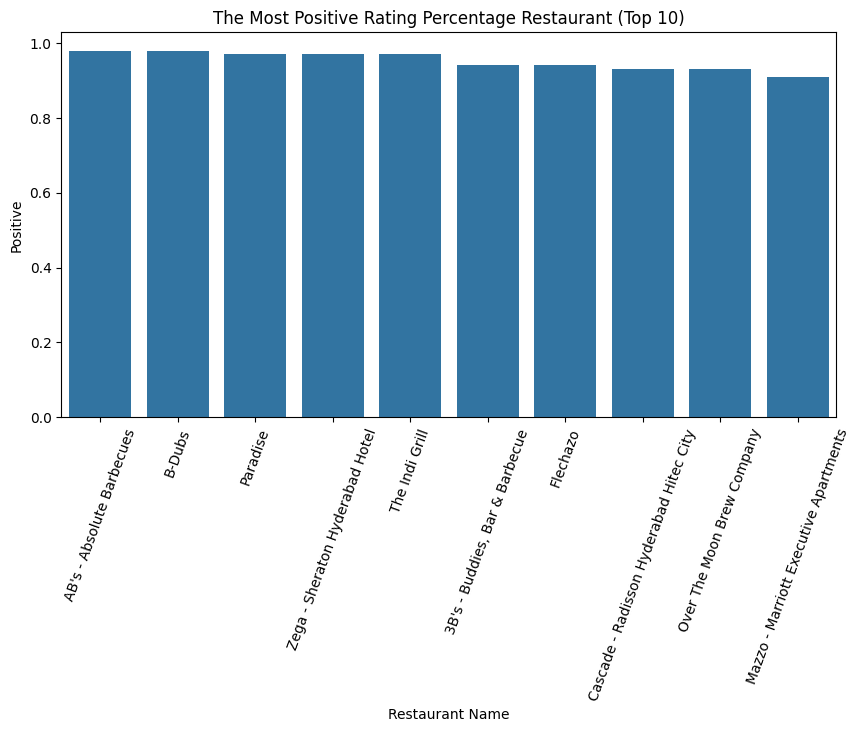

In [21]:
plt.figure(figsize=(10,5))
plt.title('The Most Positive Rating Percentage Restaurant (Top 10)')
df_piv.sort_values('Positive', ascending = False)
sns.barplot(data = df_piv.sort_values('Positive', ascending = False).head(10), x = 'Restaurant', y = 'Positive')
plt.xticks(rotation=70)
plt.xlabel('Restaurant Name')

Text(0.5, 0, 'Restaurant Name')

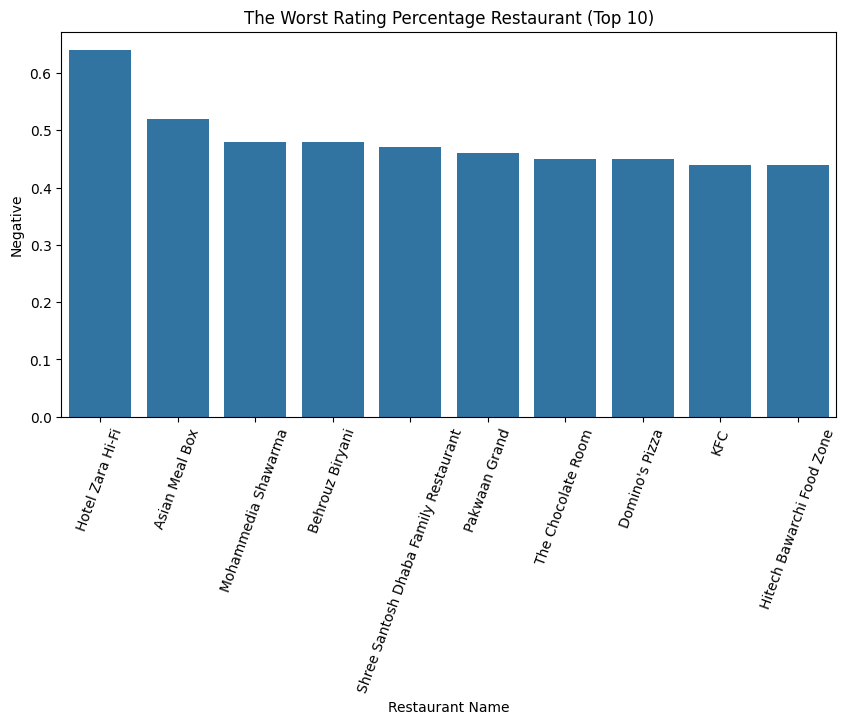

In [22]:
plt.figure(figsize=(10,5))
plt.title('The Worst Rating Percentage Restaurant (Top 10)')
df_piv.sort_values('Positive', ascending = False)
sns.barplot(data = df_piv.sort_values('Negative', ascending = False).head(10), x = 'Restaurant', y = 'Negative')
plt.xticks(rotation=70)
plt.xlabel('Restaurant Name')

In [23]:
df.Rating.value_counts(normalize = True)

,proportion
Rating,
True,0.754367
False,0.245633


# Text Preprocessing

In [24]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

ps = PorterStemmer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
reviewList = list(map(lambda data: word_tokenize(data), df["Review"]))

In [26]:
for index, word_list in enumerate(reviewList):
    reviewList[index] = " ".join([ps.stem(str(word)) for word in word_list if not word in stopwords.words("english") and word not in [".", ",", "?", "@", "$", "/"] and not word.isspace()])

In [27]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
                      "]+", re.UNICODE)

regexPuct = r"[\s\w\d]"

In [28]:
for index, word_list in enumerate(reviewList):
    reviewList[index] = re.sub(emoji_pattern, r'', word_list)
    reviewList[index] = "".join(re.findall(regexPuct, reviewList[index], re.MULTILINE))
    reviewList[index] = " ".join(reviewList[index].split())

In [29]:
df["Review"] = reviewList

In [30]:
df.head()

,Restaurant,Review,Rating,Time,Day,Month,Week,Year
0,Beyond Flavours,the ambienc good food quit good saturday lunch...,True,2019-05-25 15:54:00,Saturday,5,5,2019
1,Beyond Flavours,ambienc good pleasant even servic prompt food ...,True,2019-05-25 14:20:00,Saturday,5,5,2019
2,Beyond Flavours,a must tri great food great ambienc thnx servi...,True,2019-05-24 22:54:00,Friday,5,4,2019
3,Beyond Flavours,soumen da arun great guy onli behavior sincere...,True,2019-05-24 22:11:00,Friday,5,4,2019
4,Beyond Flavours,food goodw order kodi drumstick basket mutton ...,True,2019-05-24 21:37:00,Friday,5,4,2019


# Splitting the Data in training and testing with ratio 80:20

In [31]:
X = df["Review"]
y = df["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ML Model SVM

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,3))),
    ('classifier', SVC())
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9026593075765178

# Testing Model

In [33]:
positive_sentence = "I absolutely love this product! It has exceeded all my expectations. It's well-designed, durable, and incredibly useful. I can't imagine my life without it now. I would highly recommend it to anyone looking for a high-quality, reliable product"
negative_sentence = "I bought this product, and it was a complete waste of money. It stopped working after just a week, and the customer service was unhelpful and rude. I will never purchase anything from this company again."

In [34]:
pipeline.predict([positive_sentence, negative_sentence])

array([ True, False])

In [35]:
def preprocess(text):
    text = word_tokenize(text)
    text = " ".join([ps.stem(str(word)) for word in text if not word in stopwords.words("english") and word not in [".", ",", "?", "@", "$", "/"] and not word.isspace()])
    text = re.sub(emoji_pattern, r'', text)
    text = "".join(re.findall(regexPuct, text, re.MULTILINE))
    text = " ".join(text.split())

    return text

In [36]:
positive_sentence = preprocess(positive_sentence)
negative_sentence = preprocess(negative_sentence)

In [37]:
positive_sentence

'i absolut love product it exceed expect it s welldesign durabl incred use i ca nt imagin life without i would highli recommend anyon look highqual reliabl product'

In [38]:
negative_sentence

'i bought product complet wast money it stop work week custom servic unhelp rude i never purchas anyth compani'

In [39]:
pipeline.predict([positive_sentence, negative_sentence])

array([ True, False])